# Tutorial: HDF5 complex voltage data
This tutorial will cover how to read beamformed complex voltage data in HDF5 format.

Again, let's load the python libraries that we will use.

In [25]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
%pylab inline

Populating the interactive namespace from numpy and matplotlib


As we covered in the lecture, complex voltage data is located over 4 files, with the real and imaginary values of polarizations X and Y mapped to files as follows: $\mathrm{S0} = x_\mathrm{r}$, $\mathrm{S1} = x_\mathrm{i}$, $\mathrm{S2} = y_\mathrm{r}$ and $\mathrm{S3} = y_\mathrm{i}$.

Let's start by opening the S0 and S1 files of OBSID L645495 and reading the attributes of the `STOKES_0` group in the S0 file.

In [29]:
h5_s0 = h5py.File("L645495_SAP000_B000_S0_P000_bf.h5", "r")
h5_s1 = h5py.File("L645495_SAP000_B000_S1_P000_bf.h5", "r")

In [30]:
group = h5_s0["/SUB_ARRAY_POINTING_000/BEAM_000/STOKES_0"]
keys = sorted(["%s"%item for item in sorted(list(group.attrs))])
for key in keys:
    print(key + " = " + str(group.attrs[key]))

DATATYPE = b'float'
GROUPTYPE = b'bfData'
NOF_CHANNELS = [1 1 1 1 1 1 1 1 1 1]
NOF_SAMPLES = 117178368
NOF_SUBBANDS = 10
STOKES_COMPONENT = b'Xr'


## Exercise 1
Have a look at the output above. You'll see that the data is stored as floating point values, with 10 subbands per file. As expected, S0 contains the real value of X.

1. Now read the S1 file and inspect the Stokes group. Can you confirm that this contains the imaginary part of X?
2. Read the attribute storing the number of subbands.
3. Read the attribute storing the sampling time. Remember from the earlier tutorial that this is stored in `INCREMENT` attribute of the `/SUB_ARRAY_POINTING_XXX/BEAM_YYY/COORDINATES/COORDINATE_0` group.
4. Read the attribute storing the subband frequencies.

In [31]:
group = h5_s1["/SUB_ARRAY_POINTING_000/BEAM_000/STOKES_1"]
keys = sorted(["%s"%item for item in sorted(list(group.attrs))])
for key in keys:
    print(key + " = " + str(group.attrs[key]))

DATATYPE = b'float'
GROUPTYPE = b'bfData'
NOF_CHANNELS = [1 1 1 1 1 1 1 1 1 1]
NOF_SAMPLES = 117178368
NOF_SUBBANDS = 10
STOKES_COMPONENT = b'Xi'


In [32]:
tsamp = h5_s0["/SUB_ARRAY_POINTING_000/BEAM_000/COORDINATES/COORDINATE_0"].attrs["INCREMENT"]
nsub = h5_s0["/SUB_ARRAY_POINTING_000/BEAM_000/STOKES_0"].attrs["NOF_SUBBANDS"]
freq = h5_s0["/SUB_ARRAY_POINTING_000/BEAM_000/COORDINATES/COORDINATE_1"].attrs["AXIS_VALUES_WORLD"]
print(tsamp, nsub, freq)

5.12e-06 10 [1.37109375e+08 1.37304688e+08 1.37500000e+08 1.37695312e+08
 1.37890625e+08 1.38085938e+08 1.38281250e+08 1.38476562e+08
 1.38671875e+08 1.38867188e+08]


## Exercise 2
We now have the information to read the data in the `STOKES_0` and `STOKES_1` groups. Since the input files have 4.4GB of data each, it is better to read in parts of the timeseries, as the entire timeseries would fill up most of the memory of the computer.
1. We want to extract the timeseries between 300 and 310 seconds from the start of the observation. Using the sampling time, compute the array indices belonging to these times. (Remember that indices need to be integers).
2. Use these indices to extract the real and imaginary components of X. What is the shape of the output (use the `.shape` function of `numpy` arrays).
3. Create an array with the time of each sample in the selected range.
4. Use the slicing operations (e.g. `a[0:10, 20:22]`) to plot the first 100 samples of $x_\mathrm{r}$ and $x_\mathrm{i}$ as a function of time. Try to plot each subband seperatly (e.g. using `plt.subplot(5, 2, isub)`.)
5. What do the timeseries look like? What did you expect?

In [33]:
tmin = 300
tmax = 310
imin = int(tmin/tsamp)
imax = int(tmax/tsamp)
print(imin,imax)

58593750 60546875


In [34]:
xr = h5_s0["/SUB_ARRAY_POINTING_000/BEAM_000/STOKES_0"][imin:imax]
xi = h5_s1["/SUB_ARRAY_POINTING_000/BEAM_000/STOKES_1"][imin:imax]
print(xr.shape, xi.shape)

(1953125, 10) (1953125, 10)


In [35]:
t = np.arange(imin, imax)*tsamp

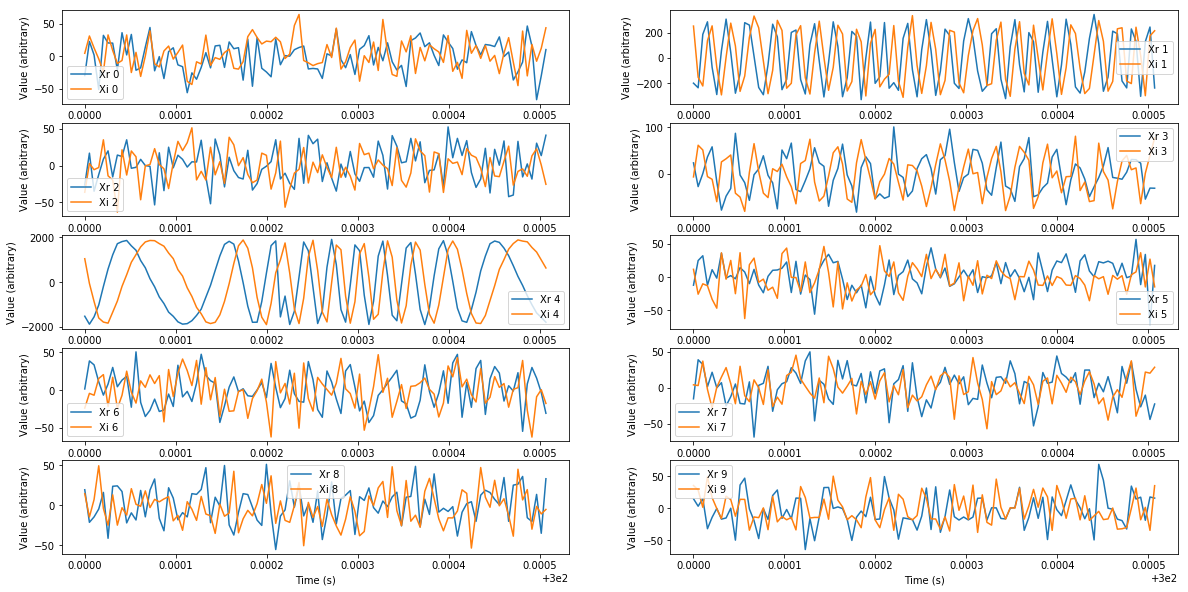

In [36]:
plt.figure(figsize=(20,10))
for isub in range(nsub):
    plt.subplot(5, 2, isub+1)
    plt.plot(t[:100], xr[:100, isub], label="Xr %d"%isub)
    plt.plot(t[:100], xi[:100, isub], label="Xi %d"%isub)
    plt.xlabel("Time (s)")
    plt.ylabel("Value (arbitrary)")
    plt.legend()

## Exercise 3
The next step is to Fourier transform the complex voltage data to generate dynamic spectra. This requires several steps, and we will go through them one by one.
1. We want the dynamic spectrum to have 1024 channels. Compute how many spectra (let's call them integrations) can be obtained from the input timeseries. Store this in a `nint` variable. (Make sure it is an integer and rounded down with e.g. `np.floor`).
2. Use the slice option to select `nchan*nint` values from the real and imaginary timeseries of X, and create a complex timeseries of the form `cin = Xreal+1j*Ximag`. What is the shape of the complex timeseries?
3. Next, we will Fourier transform the complex timeseries. Assuming it is called `cin`, use `cout = np.fft.fftshift(np.fft.fft(cin.reshape(nint, nchan, -1), axis=1), axes=1)` to perform the transform. This single command performs multiple steps: `cin.reshape(nint, nchan, -1)` reshapes the 2D array to a 3D array with shape $n_\mathrm{int}\times n_\mathrm{chan}\times n_\mathrm{sub}$, next `np.fft.fft(..., axis=1)` performs the 1D Fourier transform along axis 1, which is $n_\mathrm{chan}$. The resulting output has the two halves of the spectrum swapped, and `np.fft.fftshift..., axes=1)`, swaps the two halves back into the correct frequency order along the $n_\mathrm{chan}$ axis. What is the shape and type of the output values of `cout`?
4. `numpy` has a handy function to compute the frequencies of channels of a Fourier transform. Run `np.fft.fftfreq?` to see the usage of this function. Use this function, together with `np.fft.fftshift` to compute an array of the frequency values around the center frequency of each subband.
5. Plot the real and imaginary components of the first spectrum (`cout[0, :, isub]`) of each subband against the frequency values. Use `np.real` and `np.imag` to get the complex components.

In [37]:
nchan = 1024
nint = int(np.floor(xr.shape[0]/nchan))
print(nint,nchan,nint*nchan,xr.shape[0])

1907 1024 1952768 1953125


In [38]:
cin = xr[:nint*nchan]+1j*xi[:nint*nchan]
cin.shape

(1952768, 10)

In [39]:
cout = np.fft.fftshift(np.fft.fft(cin.reshape(nint, nchan, -1), axis=1), axes=1)

In [40]:
print(cout.shape, type(cout[0, 0, 0]))

(1907, 1024, 10) <class 'numpy.complex128'>


In [41]:
f = np.fft.fftshift(np.fft.fftfreq(nchan, d=tsamp))

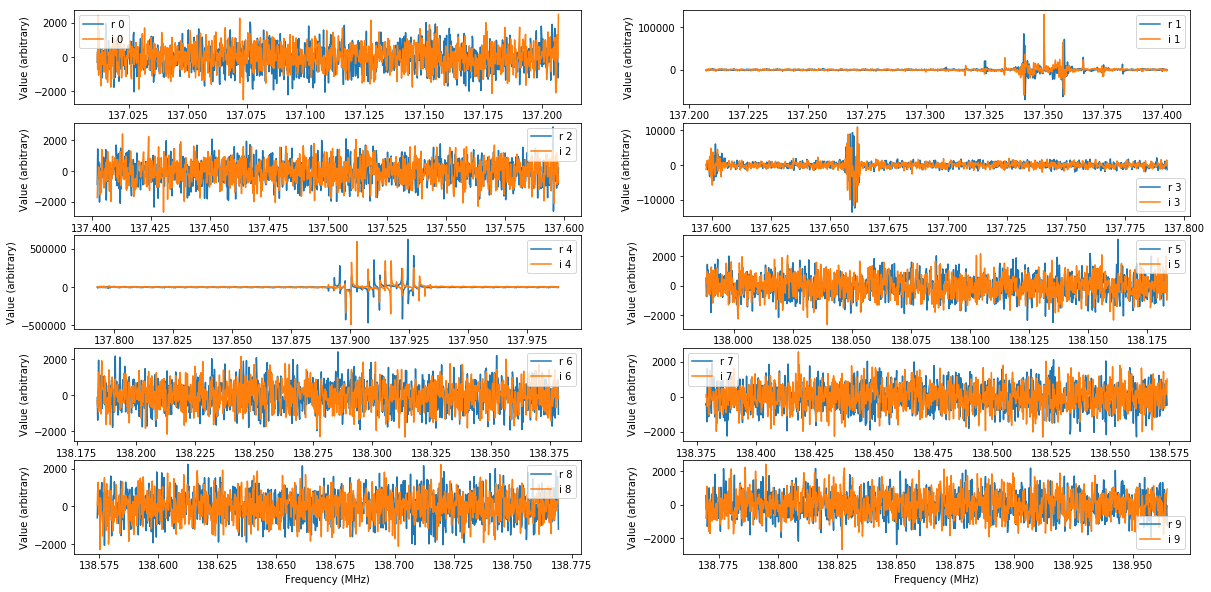

In [42]:
plt.figure(figsize=(20,10))
for isub in range(nsub):
    plt.subplot(5, 2, isub+1)
    plt.plot((freq[isub]+f)*1e-6, np.real(cout[0, :, isub]), label="r %d"%isub)
    plt.plot((freq[isub]+f)*1e-6, np.imag(cout[0, :, isub]), label="i %d"%isub)
    plt.xlabel("Frequency (MHz)")
    plt.ylabel("Value (arbitrary)")
    plt.legend()

## Exercise 4
You will recall from Michiel's lecture that the bandpass correction of COBALT is not perfect. Compute and plot the mean amplitude values (use `np.abs`) of each subband, averaged over time. Plot the amplitude values in decibels (dB: $x_\mathrm{dB}=10 \log_{10}(x)$). What can you see from the averaged bandpasses?

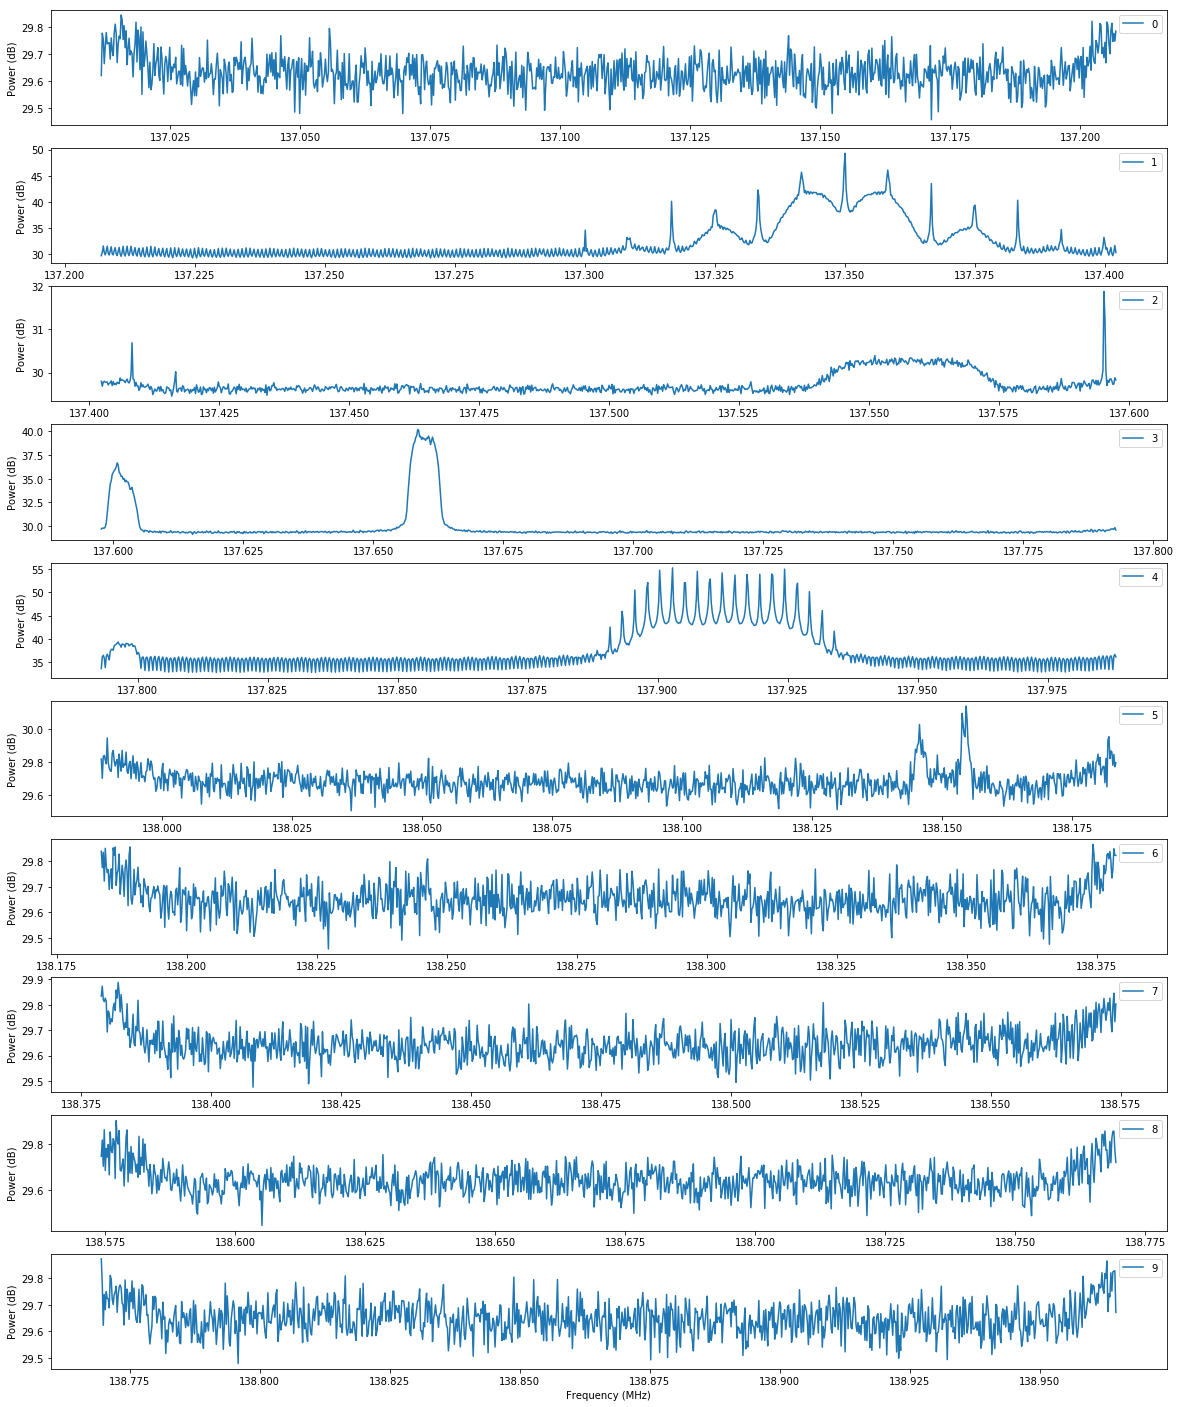

In [43]:
plt.figure(figsize=(20,25))
for isub in range(nsub):
    plt.subplot(10, 1, isub+1)
    plt.plot((freq[isub]+f)*1e-6, 10.0*np.log10(np.mean(np.abs(cout[:, :, isub]), axis=0)), label="%d"%isub)
    if isub==nsub-1:
        plt.xlabel("Frequency (MHz)")
    plt.ylabel("Power (dB)")
    plt.legend()

## Exercise 5
Let's plot dynamic spectra.
1. Compute an array with times for each spectrum.
2. Pick a subband and compute amplitudes for this subband. Convert them to decibels.
3. Plot the dynamic spectrum (using `plt.imshow`) and make sure the axes are labelled correctly.

In [44]:
t = tmin+np.arange(nint)*(tsamp*nchan)                        

In [45]:
isub = 1
amp = np.absolute(cout[:, :, isub])
amp_db = 10.0*np.log10(amp)
vmin = np.mean(amp_db)-2.0*np.std(amp_db)
vmax = np.mean(amp_db)+6.0*np.std(amp_db)

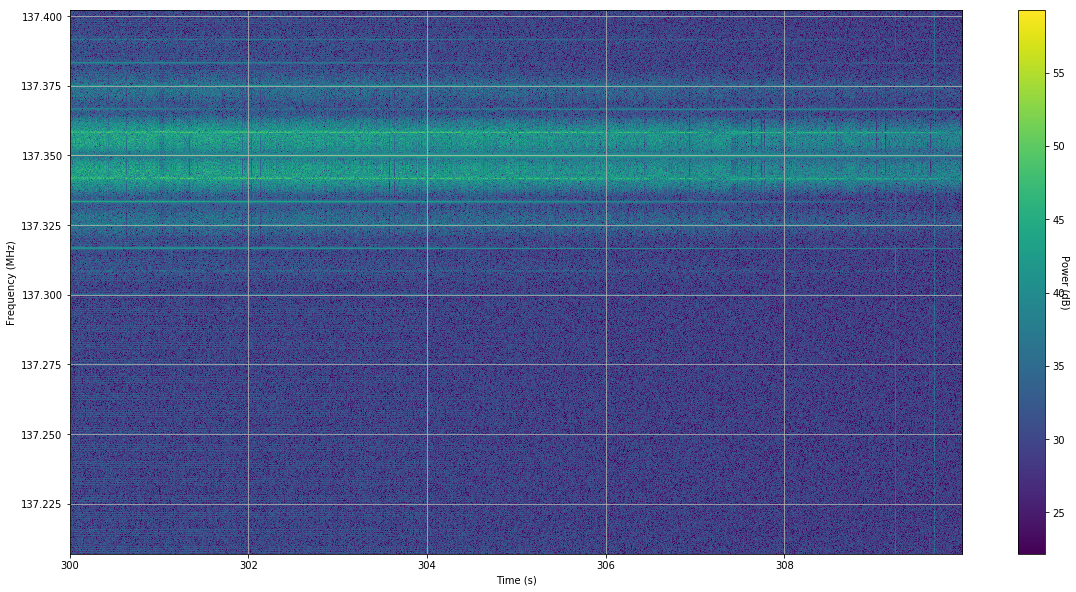

In [46]:
plt.figure(figsize=(20, 10))
plt.imshow(amp_db.T, origin='lower', aspect='auto', extent=[t[0], t[-1], (freq[isub]+f[0])*1e-6, (freq[isub]+f[-1])*1e-6], vmin=vmin, vmax=vmax)
plt.grid()
plt.xlabel("Time (s)")
plt.ylabel("Frequency (MHz)")
plt.colorbar().set_label('Power (dB)', rotation=270)